## Taxi Prices with PySpark

#### In this Notebook, we will solve a classification problem using PySpark

#### steps in the terminal before running this notebook - 


sudo yum update -y

sudo python3 -m pip install anaconda pandas scikit-learn pycm  py4j kaggle jupyter jupyterlab geopy matplotlib

tmux new -s asaf_session

export PYSPARK_DRIVER_PYTHON=jupyter

export PYSPARK_DRIVER_PYTHON_OPTS=’notebook — no-browser — ip=0.0.0.0 — port=8888'

source .bashrc

mkdir .kaggle
echo {"username":<your_user_name>, "key":<your_key>} >> .kaggle/kaggle.json   # do this with vim

pyspark    # launches jupyter with pyspark


In [2]:
# Installing the needed packages
import kaggle
!kaggle competitions download -f idc_train.csv idc-big-data-ml-competition
!sudo apt install unzip
!unzip idc_train.csv.zip
!kaggle competitions download -f idc_test.csv idc-big-data-ml-competition


idc_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
idc_test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
# checking that spark context is available
sc

<SparkContext master=yarn appName=PySparkShell>

In [2]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set("spark.executor.memory", "16g")
conf.set("spark.driver.memory", "16g")
spark_context = SparkContext.getOrCreate(conf)
spark = SparkSession(spark_context)
sc = spark

In [3]:
#Library Importing
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import date, timedelta, datetime
import time
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import functions

from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.ml.feature import Bucketizer
import numpy as np
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.clustering import KMeans
from pyspark.sql import *
from pyspark.mllib.linalg import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator;
from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier

 # confusion matrix
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as F

from pyspark.ml.feature import Imputer
from sklearn.metrics import plot_confusion_matrix
from pyspark.sql.functions import format_number as fmt

from pyspark.ml.feature import Normalizer # RobustScaler,
from pyspark.ml.feature import OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix


In [11]:
# copy the data from local fs to hadoop fs
!hadoop fs -put idc_train.csv /user/hadoop/idc_train.csv
!hadoop fs -put idc_test.csv /user/hadoop/idc_test.csv


In [4]:
%%time
sc = spark
schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("pickup_datetime", StringType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("passenger_count", DoubleType())
])


train = sc.read.csv("/user/hadoop/idc_train.csv", schema=schema, header = True)
df=  train



CPU times: user 4.38 ms, sys: 52 µs, total: 4.43 ms
Wall time: 673 ms


**Data cleaning**

In [5]:
%%time

# Removing non-relevant data (with a non-valid values)
df = df.filter((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0))  # averaging isn't relevant here - remove 0 values of location

df = df.filter((df.pickup_longitude != df.dropoff_longitude) & (df.pickup_latitude != df.dropoff_latitude) )  # remove rows where drop and pick is the same

df = df.filter((df.passenger_count > 0) &  (df.passenger_count < 6)) # maximal number of passengres is 5 in a regular car, we consider all other as outliers


# Take median values for missing values - seems better than mean
imputer = Imputer(strategy='median', missingValue=0,
                  inputCols= ["fare_amount",   "passenger_count"], 
                  outputCols=["fare_amount",   "passenger_count"]
)

imputer.fit(df).transform(df)
df = df.na.drop()  # drop rows with any nan values (for the non-numeric columns)

df.withColumn("passenger_count", df.passenger_count.cast("double"))

df = df.withColumn("high_fare", (df.fare_amount >= 10).cast('double'))

# This line is in order to see the affects of data cleaning on the dataset
# print("Size after filtering : {}".format(df.count()))

CPU times: user 26.9 ms, sys: 8.27 ms, total: 35.2 ms
Wall time: 26.5 s


**Feature Engineering**

In [6]:
%%time


# extracting hour, day, month, year of pickup date
df = df.withColumn("pickup_month", month(df.pickup_datetime))
df = df.withColumn("pickup_year", year(df.pickup_datetime))
df = df.withColumn("pickup_hour", hour(to_timestamp(df.pickup_datetime, "yyyy-MM-dd HH:mm:ss 'UTC'")))
df = df.withColumn("pickup_day", dayofweek(df.pickup_datetime))


# feature engineering - manhattan dist
df = df.withColumn(
    'fare_distance',
    abs( df.pickup_latitude - df.dropoff_latitude) +  abs(df.pickup_longitude - df.dropoff_longitude)
)


# feature engineering - travel direction
df = df.withColumn(
    'travel_direction',
    (360 - (toDegrees(atan2(   sin(df.pickup_longitude - df.dropoff_longitude) * cos(df.pickup_latitude)  , \
                    cos(df.dropoff_latitude) * sin(df.pickup_latitude) - sin(df.dropoff_latitude) *  cos(df.pickup_latitude)  * cos(df.pickup_longitude - df.dropoff_longitude)   )) + 360) % 360).cast('double')
)

# create 4 bins for direction (N/E/S/W)
bucketizer = Bucketizer(splits=[ 0, 90, 180, 270, 360 ],inputCol="travel_direction", outputCol="travel_direction_bins")
df_buck = bucketizer.setHandleInvalid("keep").transform(df)
df = df_buck

df.show()


+---+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+---------+------------+-----------+-----------+----------+--------------------+------------------+---------------------+
|key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|high_fare|pickup_month|pickup_year|pickup_hour|pickup_day|       fare_distance|  travel_direction|travel_direction_bins|
+---+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+---------+------------+-----------+-----------+----------+--------------------+------------------+---------------------+
|  1|        8.5|2010-03-30 19:27:...|       -73.96539|      40.768574|       -73.998184|       40.761074|            1.0|      0.0|           3|       2010|         19|         3| 0.04029399999999583| 77.15442209743344|                  0.0|
|  2|      35.47|2010-08-10 

In [23]:
# examining data, check the range values

df.select("travel_direction_bins").distinct().show()
# df.select("pickup_month").distinct().show()
# df.select("pickup_year").distinct().show()
# df.select("pickup_hour").distinct().show()
# df.select("pickup_day").distinct().show()


+---------------------+
|travel_direction_bins|
+---------------------+
|                  0.0|
|                  1.0|
|                  3.0|
|                  2.0|
+---------------------+



In [7]:
%%time
# K-Mean clustering of the longitude-lattitude inputs
# This is due to the fact that New York have 5 famous neighborhoods (Manhattan, Bronx, Queens, Brooklyn, Staten Island) 
# This is done for both the pickup coordinates and the dropoff coordinates

num_clusters = 20  # used 20, split each neighborhood to 4

# first, assembling the longitude+lattitude into 1 column
vecAssembler = VectorAssembler(inputCols=("pickup_longitude", "pickup_latitude"), outputCol="pickup_coordinates")
df_ = vecAssembler.transform(df)

vecAssembler = VectorAssembler(inputCols=("dropoff_longitude", "dropoff_latitude"), outputCol="dropoff_coordinates")
dataset = vecAssembler.transform(df_)

# remove non-relevant data (since we assembled these features)
df_filtered = dataset.drop("pickup_datetime").drop("pickup_longitude").drop("pickup_latitude")
df_filtered = dataset.drop("dropoff_longitude").drop("dropoff_latitude").drop("travel_direction")

kmeans = KMeans().setK(num_clusters).setSeed(1).setFeaturesCol("pickup_coordinates").setPredictionCol("pickup_area")
model = kmeans.fit(df_filtered)
predictions_ = model.transform(df_filtered)

kmeans = KMeans().setK(num_clusters).setSeed(1).setFeaturesCol("dropoff_coordinates").setPredictionCol("dropoff_area")
model = kmeans.fit(predictions_)
predictions = model.transform(predictions_)

predictions.show() 

features_ = predictions
   

+---+-----------+--------------------+----------------+---------------+---------------+---------+------------+-----------+-----------+----------+--------------------+---------------------+--------------------+--------------------+-----------+------------+
|key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|passenger_count|high_fare|pickup_month|pickup_year|pickup_hour|pickup_day|       fare_distance|travel_direction_bins|  pickup_coordinates| dropoff_coordinates|pickup_area|dropoff_area|
+---+-----------+--------------------+----------------+---------------+---------------+---------+------------+-----------+-----------+----------+--------------------+---------------------+--------------------+--------------------+-----------+------------+
|  1|        8.5|2010-03-30 19:27:...|       -73.96539|      40.768574|            1.0|      0.0|           3|       2010|         19|         3| 0.04029399999999583|                  0.0|[-73.96539,40.768...|[-73.998184,40.76...|  

In [8]:
# creating 2 new features out of date, season and daytime

# 1) According to pickup_month: season (winter - 1-3 (0), spring - 4-6 (1), summer - 7-9 (2), fall - 10-12 (3))
features__ = features_.withColumn("pickup_season", functions
              .when(((features_.pickup_month >= 1) & (features_.pickup_month <= 3)), 0) #'Winter'
              .when(((features_.pickup_month >= 4) & (features_.pickup_month <= 6)), 1) # 'Spring'
              .when(((features_.pickup_month >= 7) & (features_.pickup_month <= 9)), 2) # 'Summer'
              .when(((features_.pickup_month >= 10) & (features_.pickup_month <= 12)), 3) # 'Fall'
                .cast('double'))


#2) According to pickup_hour: day_hour (night - 23, 0-4, morning - 5-10, noon - 11-16, evening - 17-22)
# These values can be changed as we find fit..
features = features__.withColumn("pickup_day_time", functions
              .when((((features__.pickup_hour >= 0) & (features__.pickup_hour <= 4)) | (features__.pickup_hour == 23)), 0) # 'Night'
              .when(((features__.pickup_hour >= 5) & (features__.pickup_hour <= 10)), 1) # 'Morning'
              .when(((features__.pickup_hour >= 11) & (features__.pickup_hour <= 16)), 2) # 'Afternoon'
              .when(((features__.pickup_hour >= 17) & (features__.pickup_hour <= 22)), 3) # 'Evening'
                .cast('double'))

In [9]:
# dropping non-relevant data for better display of the new extracted features
features = features.drop("pickup_longitude").drop("pickup_latitude")
#.drop("pickup_year").drop("pickup_day")
features = features.drop("pickup_coordinates").drop("dropoff_coordinates")
features = features.drop("pickup_datetime")
#.drop("pickup_month").drop("pickup_hour")
features = features.drop("fare_amount")

features.show() 

+---+---------------+---------+------------+-----------+-----------+----------+--------------------+---------------------+-----------+------------+-------------+---------------+
|key|passenger_count|high_fare|pickup_month|pickup_year|pickup_hour|pickup_day|       fare_distance|travel_direction_bins|pickup_area|dropoff_area|pickup_season|pickup_day_time|
+---+---------------+---------+------------+-----------+-----------+----------+--------------------+---------------------+-----------+------------+-------------+---------------+
|  1|            1.0|      0.0|           3|       2010|         19|         3| 0.04029399999999583|                  0.0|          0|           0|          0.0|            3.0|
|  2|            1.0|      1.0|           8|       2010|         20|         3| 0.03374900000000025|                  2.0|          0|           0|          2.0|            3.0|
|  3|            1.0|      0.0|           3|       2011|         13|         1|0.017733000000006882|          

 **Data Exploration**

In [53]:
# convert to pandas and plot (first 10,000 rows)  
# without dealing with outliers
pdf = df.limit(10000).toPandas()

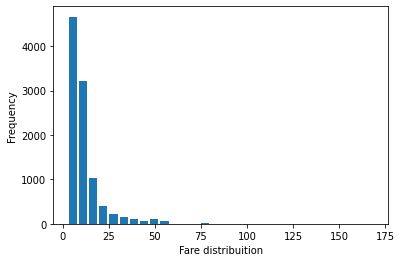

In [54]:
pdf['fare_amount'].plot(kind='hist', bins=30,rwidth=0.8)
plt.xlabel('Fare distribuition')
plt.show()

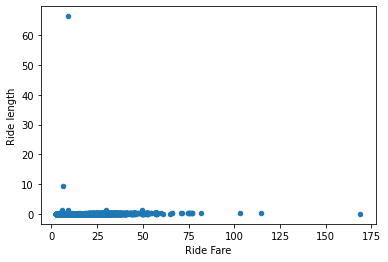

In [55]:
pdf.plot(kind='scatter',x='fare_amount',y='fare_distance')
plt.xlabel('Ride Fare')
plt.ylabel('Ride length')
plt.show()

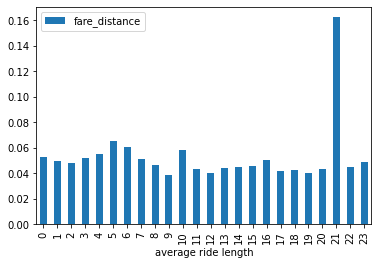

In [56]:
pdf.groupby('pickup_hour').mean().plot(kind='bar',y='fare_distance')
plt.xlabel('Hour of day')
plt.xlabel('average ride length')

plt.show()

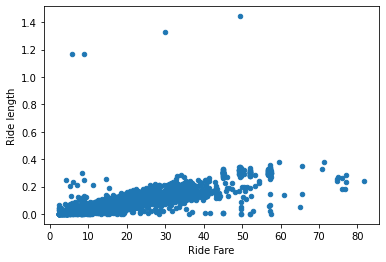

In [57]:
# convert to pandas and plot (first 10,000 rows)  
# this is set to handle with the outliers, 
# seen on the first graph of Ride Fare Vs. Ride length
df_filtered = df.filter(((df.fare_amount > 0) &  (df.fare_amount < 100)))
df_filtered = df_filtered.filter(((df_filtered.fare_distance > 0) &  (df_filtered.fare_distance < 5)))
pdf_filtered = df_filtered.limit(10000).toPandas()
# same graph as above, with the outliers removal
# dealing with outliers
pdf_filtered.plot(kind='scatter',x='fare_amount',y='fare_distance')
plt.xlabel('Ride Fare')
plt.ylabel('Ride length')
plt.show()

In [10]:
# dealing with the outliers, to match the second graph we displayed
features = features.filter(((features.fare_distance > 0) &  (features.fare_distance < 5)))

***TRAINING and VALIDATION - Logistic Regression and Gradient Boosted Trees***

In [11]:
# function to print the area under the curve

#Function which will calcualte f1 scores:
def model_performance(model, test_data, metric = 'areaUnderROC'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = BinaryClassificationEvaluator( labelCol="high_fare").setMetricName(metric)
    
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    return score

In [12]:
#1hot encoding for numerical features - ended up not using this!
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel

encoder = OneHotEncoderEstimator(inputCols=["travel_direction_bins", "pickup_area", "dropoff_area", "pickup_season", "pickup_day_time",\
                                   "pickup_year", "pickup_month", "pickup_day", "pickup_hour"],
                        outputCols=["travel_direction_bins_1hot", "pickup_area_1hot", "dropoff_area_1hot", "pickup_season_1hot", "pickup_day_time_1hot",\
                                   "pickup_year_1hot", "pickup_month_1hot", "pickup_day_1hot", "pickup_hour_1hot"])
model = encoder.fit(features)
encoded_features = model.transform(features)

In [12]:
# Splitting training data into train, test
# training, test = encoded_features.randomSplit([0.8, 0.2]);
training, test = features.randomSplit([0.8, 0.2]);

***Logistic Reggression - area under the ROC curve score***

In [47]:
%%time

# Creating the model of the logistic reggression

#create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["passenger_count", "pickup_season", "pickup_day_time", "fare_distance", "pickup_area", "dropoff_area", "travel_direction_bins"],\
                            outputCol="classifier_input")




scaler = StandardScaler(inputCol="classifier_input", outputCol="Features", withMean=False)  # normalize features

model_lr = LogisticRegression(featuresCol="Features", labelCol="high_fare") 

pipeline_lr = Pipeline(stages=[assembler, scaler, model_lr])

# area under the ROC curve score
# Training with logistic regression
model_lr_fitted = pipeline_lr.fit(training)
model_performance(model_lr_fitted, test)

CPU times: user 60 ms, sys: 22.6 ms, total: 82.6 ms
Wall time: 1min 51s


0.9202767067559607

***Logistic Reggression - confusion matrix***

In [16]:
%%time

# Compute raw scores on the test set
#select only prediction and label columns
predictions = model_lr_fitted.transform(test)

# predictions
y_true = predictions.select(['high_fare']).collect()
y_pred = predictions.select(['prediction']).collect()
print(confusion_matrix(y_true, y_pred, normalize='all'))


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


[[0.57107207 0.03880614]
 [0.10201398 0.28810781]]
CPU times: user 3min 33s, sys: 1.62 s, total: 3min 35s
Wall time: 7min 10s


***Gradient Boost Tree - area under the ROC curve score - 1 slave fit***

In [18]:
%%time
# Creating the model of the gradient boost tree

assembler_gbt = VectorAssembler(inputCols=["passenger_count", "pickup_season", "pickup_day_time", "fare_distance", "pickup_area", "dropoff_area", "travel_direction_bins", "pickup_year", "pickup_month", "pickup_day", "pickup_hour"],\
                            outputCol="gbt_classifier_input")
scaler = StandardScaler(inputCol="gbt_classifier_input", outputCol="features_gbt", withMean=True)  # normalize features
gbt = GBTClassifier(labelCol="high_fare", featuresCol="features_gbt", maxIter=9)

pipeline_gbt = Pipeline(stages=[assembler_gbt, scaler,  gbt])

model_gbt_fitted = pipeline_gbt.fit(training)
model_performance(model_gbt_fitted, test)

CPU times: user 106 ms, sys: 18.1 ms, total: 124 ms
Wall time: 5min 23s


0.9373511994745083

***Gradient Boost Tree - area under the ROC curve score - 10 slave fit***

In [21]:
%%time
# Creating the model of the gradient boost tree

assembler_gbt = VectorAssembler(inputCols=["passenger_count", "pickup_season", "pickup_day_time", "fare_distance", "pickup_area", "dropoff_area", "travel_direction_bins", "pickup_year", "pickup_month", "pickup_day", "pickup_hour"],\
                            outputCol="gbt_classifier_input")
scaler = StandardScaler(inputCol="gbt_classifier_input", outputCol="features_gbt")  # normalize features
gbt = GBTClassifier(labelCol="high_fare", featuresCol="features_gbt", maxIter=10)

pipeline_gbt = Pipeline(stages=[assembler_gbt, scaler,  gbt])

model_gbt_fitted = pipeline_gbt.fit(training)
model_performance(model_gbt_fitted, test)

CPU times: user 101 ms, sys: 23.6 ms, total: 124 ms
Wall time: 5min 34s


0.9376746581680824

In [14]:
%%time

# Compute raw scores on the test set
predictions = model_gbt_fitted.transform(test)
predictions.show()

+---+---------------+---------+------------+-----------+-----------+----------+--------------------+---------------------+-----------+------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+
|key|passenger_count|high_fare|pickup_month|pickup_year|pickup_hour|pickup_day|       fare_distance|travel_direction_bins|pickup_area|dropoff_area|pickup_season|pickup_day_time|gbt_classifier_input|        features_gbt|       rawPrediction|         probability|prediction|
+---+---------------+---------+------------+-----------+-----------+----------+--------------------+---------------------+-----------+------------+-------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+
|  5|            1.0|      0.0|          12|       2011|         13|         7| 0.02819699999999159|                  0.0|          0|           0|          3.0|            2.0|[1.0

***Gradient Boost Tree - confusion matrix***

In [14]:
%%time
# predictions = model_gbt_fitted.transform(test)

# predictions
y_true = predictions.select(['high_fare']).collect()
y_pred = predictions.select(['prediction']).collect()
print(confusion_matrix(y_true, y_pred, normalize='all'))

[[0.5645981  0.04548553]
 [0.08191658 0.30799979]]
CPU times: user 3min 54s, sys: 2.12 s, total: 3min 56s
Wall time: 16min 15s


***MultiLayer Perceptron***

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator




# specify layers for the neural network:
# input layer of size 11 (features), two intermediate of size 8 and 6
# and output of size 2 (classes)
layers = [11, 8, 6, 2]



# train the model
model = trainer.fit(train)



assembler_mlp = VectorAssembler(inputCols=["passenger_count", "pickup_season", "pickup_day_time", "fare_distance", "pickup_area", "dropoff_area", "travel_direction_bins", "pickup_year", "pickup_month", "pickup_day", "pickup_hour"],\
                            outputCol="mlp_classifier_input")
scaler = StandardScaler(inputCol="mlp_classifier_input", outputCol="features_mlp", withMean=True)  # normalize features
# gbt = GBTClassifier(labelCol="high_fare", featuresCol="features_gbt")
mlp = MultilayerPerceptronClassifier(labelCol="high_fare", featuresCol="features_gbt", maxIter=100, layers=layers, blockSize=128, seed=1234)

pipeline_mlp = Pipeline(stages=[assembler_mlp, scaler,  mlp])

model_mlp_fitted = pipeline_mlp.fit(training)
model_performance(model_mlp_fitted, test)


# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

In [ ]:
# Compute raw scores on the test set
predictions = model_mlp_fitted.transform(test)
# predictions.show()

y_true = predictions.select(['high_fare']).collect()
y_pred = predictions.select(['prediction']).collect()
print(confusion_matrix(y_true, y_pred, normalize='all'))

***Predicting Test Results***

***Working on the test set file***

In [22]:
%%time

# get the test data ready for prediction 
schema = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", StringType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("passenger_count", DoubleType())
])


df = sc.read.csv("/user/hadoop/idc_test.csv", schema=schema, header = True)
print("Size : {}".format(df.count()))

# Take median values for missing values
imputer = Imputer(strategy='mean', missingValue=0,
                  inputCols= ["passenger_count"], 
                  outputCols=[ "passenger_count"]
)

imputer.fit(df).transform(df)
df.withColumn("passenger_count", df.passenger_count.cast("double"))



# extracting hour, day, month, year of pickup date
df = df.withColumn("pickup_month", month(df.pickup_datetime))
df = df.withColumn("pickup_year", year(df.pickup_datetime))
df = df.withColumn("pickup_hour", hour(to_timestamp(df.pickup_datetime, "yyyy-MM-dd HH:mm:ss 'UTC'")))
df = df.withColumn("pickup_day", dayofweek(df.pickup_datetime))


# feature engineering - manhattan dist
df = df.withColumn(
    'fare_distance',
    abs( df.pickup_latitude - df.dropoff_latitude) +  abs(df.pickup_longitude - df.dropoff_longitude)
)


# feature engineering - travel direction
df = df.withColumn(
    'travel_direction',
    (360 - (toDegrees(atan2(   sin(df.pickup_longitude - df.dropoff_longitude) * cos(df.pickup_latitude)  , \
                    cos(df.dropoff_latitude) * sin(df.pickup_latitude) - sin(df.dropoff_latitude) *  cos(df.pickup_latitude)  * cos(df.pickup_longitude - df.dropoff_longitude)   )) + 360) % 360).cast('double')
)

# create 4 bins for direction (N/E/S/W)
bucketizer = Bucketizer(splits=[ 0, 90, 180, 270, 360 ],inputCol="travel_direction", outputCol="travel_direction_bins")
df_buck = bucketizer.setHandleInvalid("keep").transform(df)
df = df_buck




# first, assembling the longitude+lattitude into 1 column
vecAssembler = VectorAssembler(inputCols=("pickup_longitude", "pickup_latitude"), outputCol="pickup_coordinates")
df_ = vecAssembler.transform(df)

vecAssembler = VectorAssembler(inputCols=("dropoff_longitude", "dropoff_latitude"), outputCol="dropoff_coordinates")
dataset = vecAssembler.transform(df_)

# remove non-relevant data (since we assembled these features)
df_filtered = dataset.drop("pickup_datetime").drop("pickup_longitude").drop("pickup_latitude")
df_filtered = dataset.drop("dropoff_longitude").drop("dropoff_latitude").drop("travel_direction")

kmeans = KMeans().setK(num_clusters).setSeed(1).setFeaturesCol("pickup_coordinates").setPredictionCol("pickup_area")
model = kmeans.fit(df_filtered)
predictions_ = model.transform(df_filtered)

kmeans = KMeans().setK(num_clusters).setSeed(1).setFeaturesCol("dropoff_coordinates").setPredictionCol("dropoff_area")
model = kmeans.fit(predictions_)
predictions = model.transform(predictions_)


features_ = predictions


from pyspark.sql import functions
#TODO: create 2 new features out of date: 
# 1) According to pickup_month: season (winter - 1-3 (0), spring - 4-6 (1), summer - 7-9 (2), fall - 10-12 (3))
features__ = features_.withColumn("pickup_season", functions
              .when(((features_.pickup_month >= 1) & (features_.pickup_month <= 3)), 0) #'Winter'
              .when(((features_.pickup_month >= 4) & (features_.pickup_month <= 6)), 1) # 'Spring'
              .when(((features_.pickup_month >= 7) & (features_.pickup_month <= 9)), 2) # 'Summer'
              .when(((features_.pickup_month >= 10) & (features_.pickup_month <= 12)), 3) # 'Fall'
                .cast('double'))


#2) According to pickup_hour: day_hour (night - 23, 0-4, morning - 5-10, noon - 11-16, evening - 17-22)
# These values can be changed as we find fit..
features = features__.withColumn("pickup_day_time", functions
              .when((((features__.pickup_hour >= 0) & (features__.pickup_hour <= 4)) | (features__.pickup_hour == 23)), 0) # 'Night'
              .when(((features__.pickup_hour >= 5) & (features__.pickup_hour <= 10)), 1) # 'Morning'
              .when(((features__.pickup_hour >= 11) & (features__.pickup_hour <= 16)), 2) # 'Afternoon'
              .when(((features__.pickup_hour >= 17) & (features__.pickup_hour <= 22)), 3) # 'Evening'
                .cast('double'))


# dropping non-relevant data for better display of the new extracted features
features = features.drop("pickup_longitude").drop("pickup_latitude")
#.drop("pickup_year").drop("pickup_day")
features = features.drop("pickup_coordinates").drop("dropoff_coordinates")
features = features.drop("pickup_datetime")
#.drop("pickup_month").drop("pickup_hour")
features = features.drop("fare_amount")


encoded_features = features

predictions = model_gbt_fitted.transform(encoded_features)
#predictions = model_lr_fitted.transform(test_data)


predictions = predictions.drop("fare_distance").drop("travel_direction_bins").drop("pickup_area").drop("dropoff_area").drop("pickup_season").drop("pickup_day_time").drop("gbt_classifier_input")\
.drop("features_gbt").drop("rawPrediction").drop("probability").drop("passenger_count")
predictions = predictions.selectExpr("key as key", "prediction as high_fare")  # rename accordingly
# predictions.show()


Size : 10000
CPU times: user 119 ms, sys: 28.4 ms, total: 147 ms
Wall time: 5.96 s


In [24]:
predictions.show()

# creating the submission file
predictions.write.csv('submission2.csv', header='true')

+--------+---------+
|     key|high_fare|
+--------+---------+
|19990001|      0.0|
|19990002|      1.0|
|19990003|      0.0|
|19990004|      0.0|
|19990005|      0.0|
|19990006|      0.0|
|19990007|      0.0|
|19990008|      0.0|
|19990009|      0.0|
|19990010|      0.0|
|19990011|      1.0|
|19990012|      0.0|
|19990013|      0.0|
|19990014|      0.0|
|19990015|      1.0|
|19990016|      0.0|
|19990017|      0.0|
|19990018|      0.0|
|19990019|      1.0|
|19990020|      1.0|
+--------+---------+
only showing top 20 rows



In [25]:
# copy results from hadoop fs to local
!hadoop fs -get submission2.csv .